# Impact of clustering on classification results, and stats

The purpose of this notebook is to observe how the data responds to being clustered by cd-hit at different threshold.

In a second step, we perform deterministic randomized undersampling, to determine the smallest number of samples that leads to good classification results.

Then, we undersample the majority class, to test whether that makes its score approach that of the minority class.

Finally, we recreated some of the plots from Notebook 2, after a 70% cluster threshold has been applied.

## Imports

In [23]:
from subpred.transporter_dataset import create_dataset, get_clustering_stats
from subpred.compositions import calculate_aac, calculate_paac
from subpred.plots import (
    labeled_clustermap,
    pca_plot_2d,
    pca_plot_3d,
    perform_pca,
    feature_importance_plot,
    downsample_majority_class_plot,
    downsampling_plot
)
from subpred.util import get_clusters
from subpred.cdhit import cd_hit
import seaborn as sns

In [2]:
df = create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    outliers= ['P76773', 'Q47706', 'P02943', 'P75733', 'P69856'],
    verbose = True,
    tax_ids_filter = [83333],
    output_log = "../logs/ecoli_amino_sugar_dataset.log",
)

In [3]:
df_stats_long = get_clustering_stats(df)
df_stats_long

,identity_threshold,kw_type,keyword,count
0,40,keywords_location,Cell inner membrane,88
1,40,keywords_location,Cell membrane,89
2,40,keywords_location,Membrane,89
3,40,keywords_location,Transmembrane,89
4,40,keywords_transport,Amino-acid transport,47
...,...,...,...,...
86,100,keywords_transport_related,Transport,100
87,100,tcdb_class,0.0,5
88,100,tcdb_class,2.A,55
89,100,tcdb_class,3.A,23


In [4]:
def pivot(df_stats_long, kw_type):
    return df_stats_long[df_stats_long.kw_type == kw_type].pivot(
        index="identity_threshold", columns="keyword", values="count"
    ).fillna(0).convert_dtypes(int)

In contrast to A thaliana, considerably less transporters are removed through clustering. This means that the unclustered dataset has a more diverse set of transporters.

keyword,Amino-acid transport,Sugar transport
identity_threshold,,
40,47,42
50,49,45
60,50,45
70,52,47
80,52,48
90,52,48
100,52,48


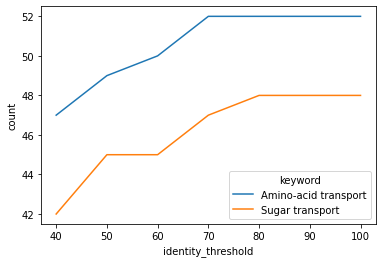

In [5]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport")

We already filter for "Transmembrane", so the only difference is in the cell inner membrane keyword. One protein is not annotated with that, but it is also in the inner membrane according to GO (see last notebooks) 

keyword,Cell inner membrane,Cell membrane,Membrane,Transmembrane
identity_threshold,,,,
40,88,89,89,89
50,93,94,94,94
60,94,95,95,95
70,98,99,99,99
80,99,100,100,100
90,99,100,100,100
100,99,100,100,100


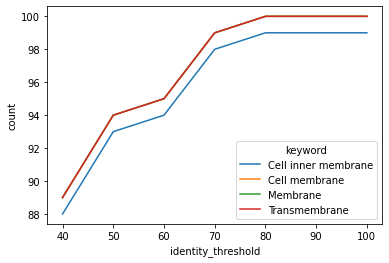

In [6]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_location"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_location")

keyword,Antiport,Symport,Transport
identity_threshold,,,
40,5,15,89
50,5,15,94
60,5,15,95
70,5,16,99
80,5,16,100
90,5,16,100
100,5,16,100


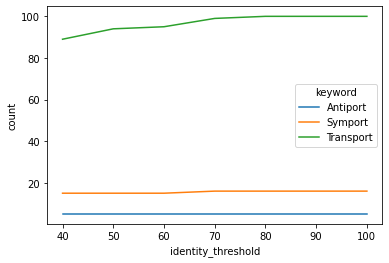

In [7]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "keywords_transport_related"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "keywords_transport_related")

keyword,0.0,2.A,3.A,4.A
identity_threshold,,,,
40,5,45,23,16
50,5,49,23,17
60,5,50,23,17
70,5,54,23,17
80,5,55,23,17
90,5,55,23,17
100,5,55,23,17


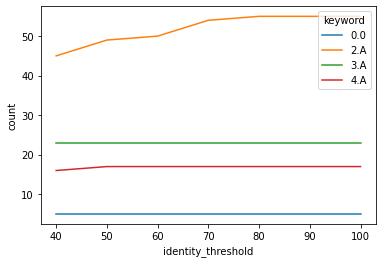

In [8]:
sns.lineplot(
    data=df_stats_long[df_stats_long.kw_type == "tcdb_class"],
    x="identity_threshold",
    y="count",
    hue="keyword",
)
pivot(df_stats_long, "tcdb_class")

Again, the performance drops sharply if the number of samples drops below about 20-30 per class.

<AxesSubplot:xlabel='Total Samples', ylabel='Score'>

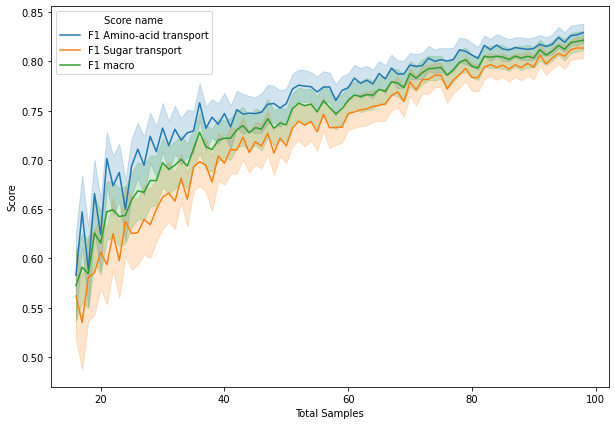

In [9]:
df_aac = calculate_aac(df.sequence)
labels = df.keywords_transport.rename("labels")

downsampling_plot(df_aac, labels)

Downsampling the majority class does not really make sense here, since the dataset is almost balanced

In [21]:
# df_aac = calculate_aac(df.sequence)
# labels = df.keywords_transport.rename("labels")
# downsample_majority_class_plot(df_aac, labels, n_jobs=1)

## Plots at 70% cluster threshold


In [25]:
cluster_representatives_70 = cd_hit(df.sequence, identity_threshold=70)
df_clustered = df.loc[cluster_representatives_70]

cd-hit: clustered 100 sequences into 99 clusters at threshold 70


In [26]:
df_aac_clustered = calculate_aac(df_clustered.sequence)
df_paac_clustered = calculate_paac(df_clustered.sequence)
labels_clustered = df_clustered.keywords_transport.rename("labels")

### Feature importance


In contrast to A thaliana, the clustering does not change the AAC in a significant way. This is because fewer samples are removed.

<AxesSubplot:xlabel='Feature', ylabel='Normalized score'>

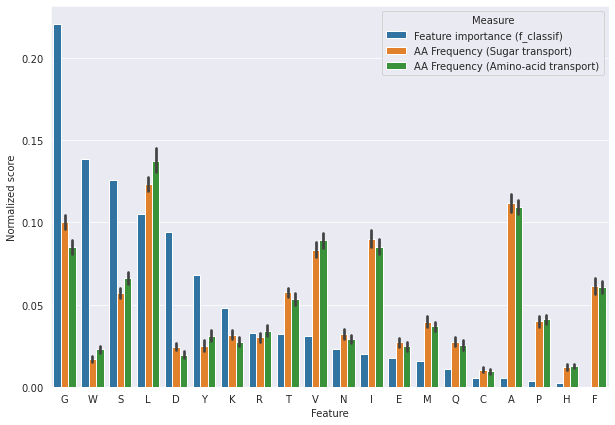

In [31]:
feature_importance_plot(df_aac_clustered, labels_clustered, method="f_classif")

### PCA



#### AAC

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

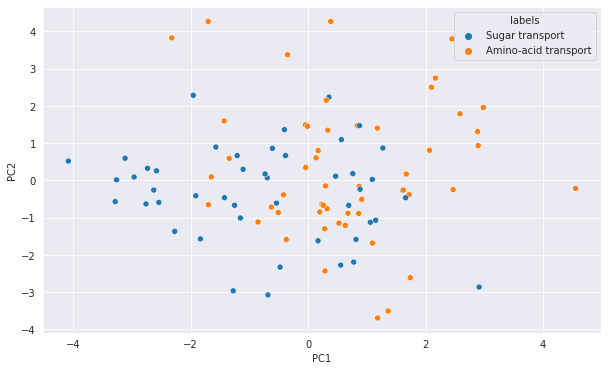

In [32]:
pca_plot_2d(df_aac_clustered, labels_clustered)

#### PAAC

The two outliers in terms of sequence from notebook 2 still persist, as expected because of their low homology to other transporters. We will try removing them during evaluation, and comparing the results. A good set of SVM parameters could also take care of it.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

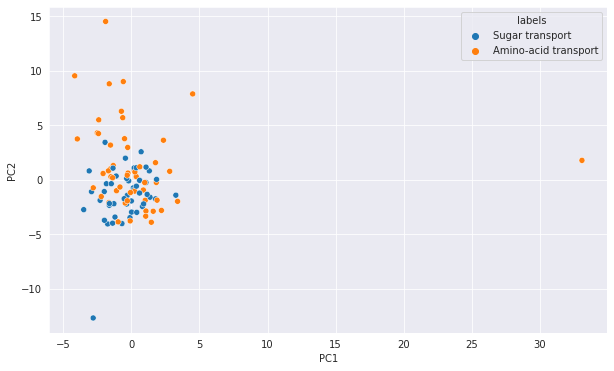

In [33]:
pca_plot_2d(df_paac_clustered, labels_clustered)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

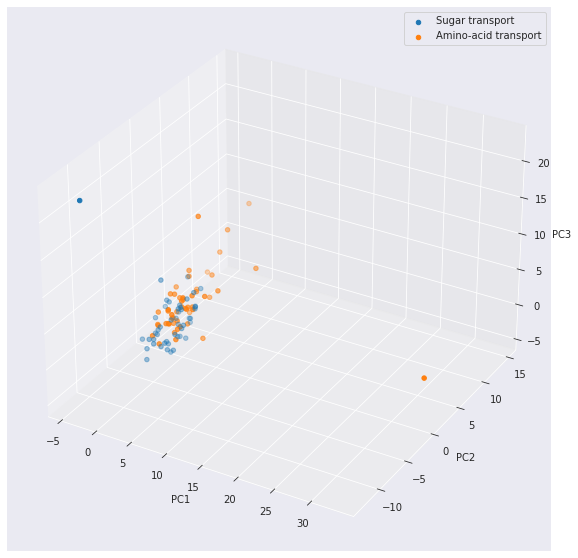

In [35]:
pca_plot_3d(df_paac_clustered, labels_clustered)

The classes 2 and 4 are relatively mixed together on the first two components, the active transporters have higher PC2 values.

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

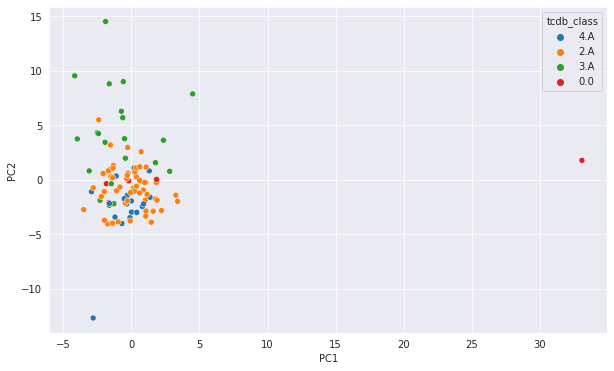

In [42]:
pca_plot_2d(df_paac_clustered, df.tcdb_class)

<Axes3DSubplot:xlabel='PC1', ylabel='PC2'>

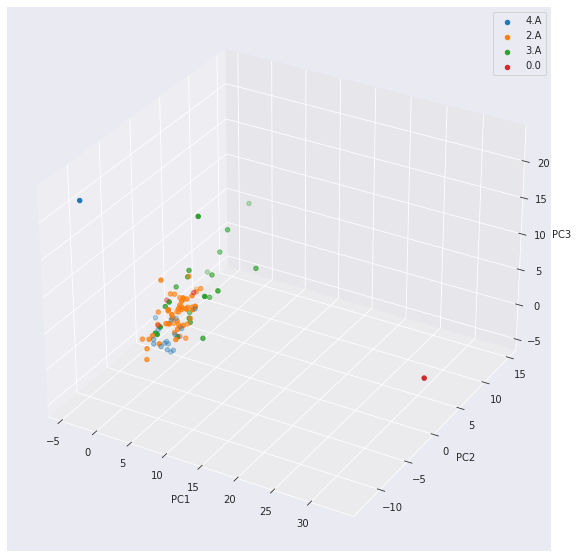

In [43]:
pca_plot_3d(df_paac_clustered, df.tcdb_class)

Nothing notable about other annotations

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

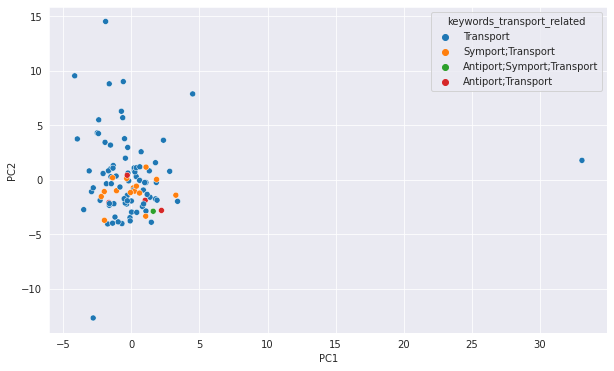

In [48]:
pca_plot_2d(df_paac_clustered, df.keywords_transport_related)

## Clustering heatmaps

Classes are still not separable very well through hierarchical clustering, but there is a pattern

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fcaf4912b50>)

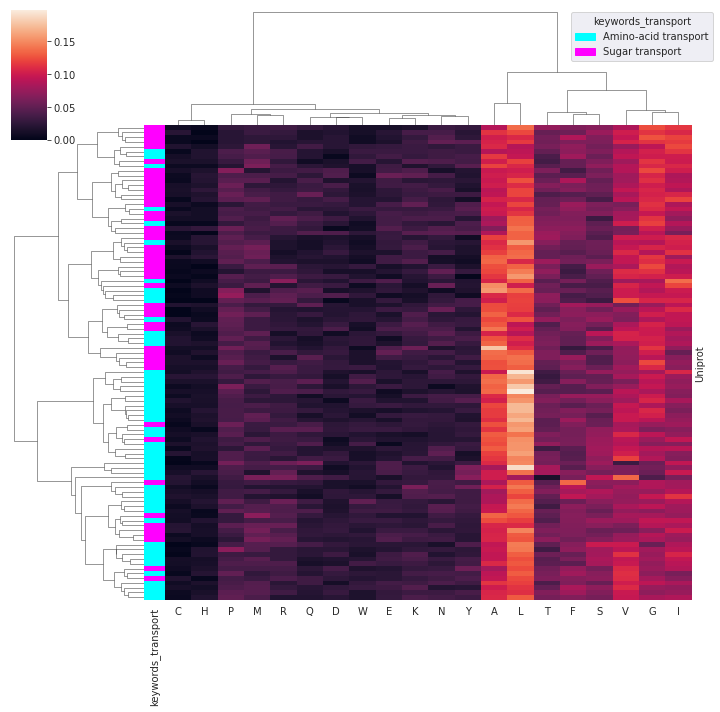

In [36]:
labeled_clustermap(df_aac_clustered, df_clustered.keywords_transport, xlabels="auto")

({'Amino-acid transport': 'cyan', 'Sugar transport': 'magenta'},
 <seaborn.matrix.ClusterGrid at 0x7fcaf4912e20>)

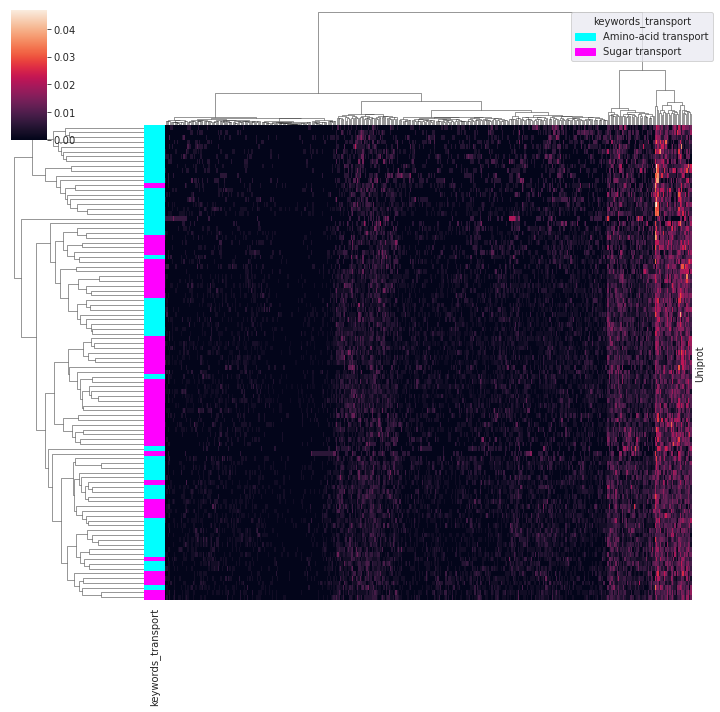

In [37]:
labeled_clustermap(df_paac_clustered, df_clustered.keywords_transport)

({'0.0': 'cyan', '2.A': 'magenta', '3.A': 'yellow', '4.A': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7fcb07e22130>)

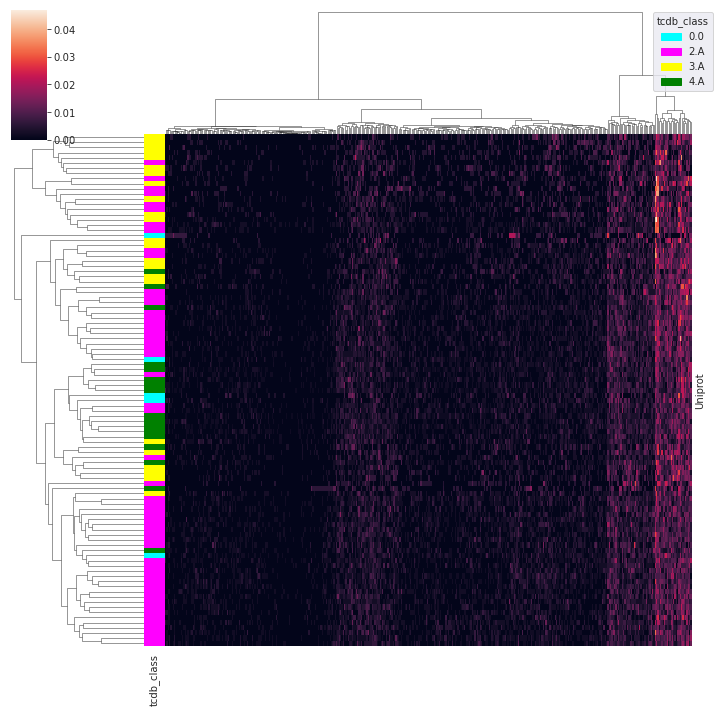

In [38]:
labeled_clustermap(df_paac_clustered, df_clustered.tcdb_class)

There seem to be three clusters: One with only Transport, one that contains the antiporters, and one that contains the symporters. 

({'Antiport;Symport;Transport': 'cyan',
  'Antiport;Transport': 'magenta',
  'Symport;Transport': 'yellow',
  'Transport': 'green'},
 <seaborn.matrix.ClusterGrid at 0x7fcaf3f0e9a0>)

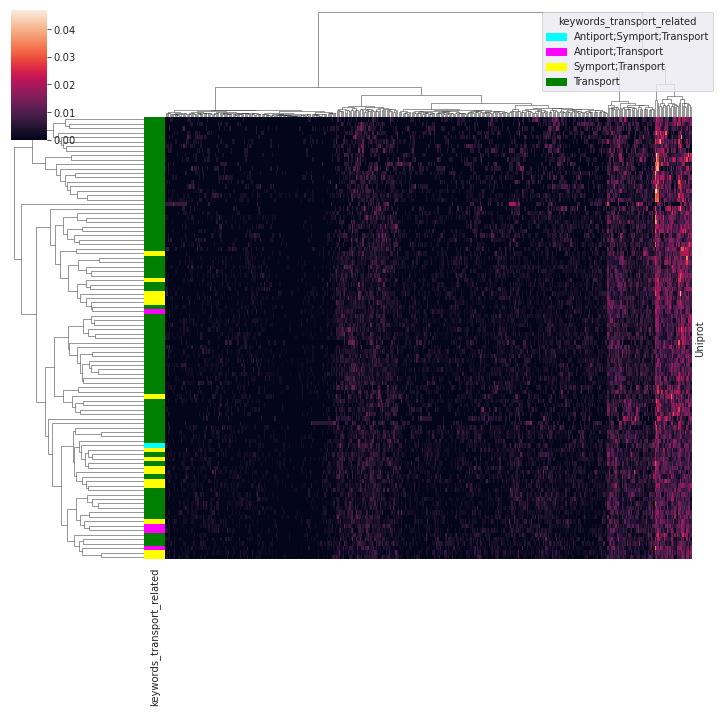

In [39]:
labeled_clustermap(df_paac_clustered, df_clustered.keywords_transport_related)